In [ ]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report
import cv2

import numpy as np
import tensorflow as tf

np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
# Step 1: Upload and Extract the Zip File
from google.colab import files
import zipfile
import os

# Upload the zip file containing the dataset
uploaded = files.upload()

# Extract the zip file into an "archive" folder
for file_name in uploaded.keys():
    with zipfile.ZipFile(file_name, 'r') as zip_ref: # Use file_name instead of archive()
        zip_ref.extractall("archive")  # Extract into the "archive" folder

# Check the contents of the archive folder
os.listdir("archive")

Saving archive (6).zip to archive (6).zip


['train', 'valid', 'rails.csv', 'test']

In [ ]:
# Step 2: Load the Dataset
import pandas as pd

# Load the dataset CSV file
df = pd.read_csv('archive/rails.csv')  # Adjust the path if necessary
print(df.head())  # Display the first few rows of the dataframe

   class index                                          filepaths     labels  \
0            0  train/Defective/131004959_171473721383413_8222...  Defective   
1            0  train/Defective/131051004_382613492830631_1306...  Defective   
2            0  train/Defective/131065180_999185033824671_7735...  Defective   
3            0  train/Defective/131084537_190751489449739_2798...  Defective   
4            0  train/Defective/131092897_149705809860659_8798...  Defective   

  data set  
0    train  
1    train  
2    train  
3    train  
4    train  


In [ ]:
# Step 3: Define Image Preprocessing and Loading Functions
import cv2
import numpy as np

# Image dimensions
IMG_HEIGHT = 150
IMG_WIDTH = 150
BATCH_SIZE = 64

# Function to load and preprocess images
def load_and_preprocess_image(img_path):
    img = cv2.imread(img_path)
    if img is not None:
        img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
        img = img / 255.0  # Normalize pixel values
    return img

# Function to load dataset from DataFrame
def load_dataset(df, dataset_type):
    data = df[df['data set'] == dataset_type]
    images = []
    labels = []

    for index, row in data.iterrows():
        img_path = os.path.join("archive", row['filepaths'])  # Path to the images
        label = row['class index']  # 0 = defective, 1 = non-defective

        img = load_and_preprocess_image(img_path)
        if img is not None:
            images.append(img)
            labels.append(label)

    return np.array(images), np.array(labels)

In [ ]:
# Step 4: Load Train, Validation, and Test Datasets
train_images, train_labels = load_dataset(df, 'train')
valid_images, valid_labels = load_dataset(df, 'valid')
test_images, test_labels = load_dataset(df, 'test')

NameError: name 'df' is not defined

In [ ]:
# --- Start of Data Augmentation Section ---
# Create an image data generator with augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
)

# Fit the generator on the training data
train_generator = datagen.flow(train_images, train_labels, batch_size=32)
valid_generator = datagen.flow(valid_images, valid_labels, batch_size=32)
test_generator = datagen.flow(test_images, test_labels, batch_size=32)
# --- End of Data Augmentation Section ---

In [ ]:
# --- Start of Transfer Learning with VGG16 ---
# Import the VGG16 model
from tensorflow.keras.applications import VGG16

# Load VGG16 model with pretrained weights, excluding the top layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Freeze the base model
for layer in base_model.layers:
    layer.trainable = False

# Create a new model on top
from tensorflow.keras import models, layers # Make sure to import layers and models
model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),  # Dropout to prevent overfitting
    layers.Dense(1, activation='sigmoid')  # Sigmoid for binary classification
])
# --- End of Transfer Learning Section ---

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Set early stopping
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau # Import callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)

In [ ]:
# Step 6: Train the Model
history = model.fit(
    train_images, train_labels,
    validation_data=(valid_images, valid_labels),
    epochs=15,
    batch_size=BATCH_SIZE
)

Epoch 1/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 852ms/step - accuracy: 0.5436 - loss: 2.5242 - val_accuracy: 0.5000 - val_loss: 1.4001
Epoch 2/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 167ms/step - accuracy: 0.5713 - loss: 1.0350 - val_accuracy: 0.5323 - val_loss: 1.0575
Epoch 3/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step - accuracy: 0.6123 - loss: 0.8302 - val_accuracy: 0.6935 - val_loss: 0.5904
Epoch 4/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 167ms/step - accuracy: 0.7350 - loss: 0.5944 - val_accuracy: 0.7581 - val_loss: 0.5023
Epoch 5/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 166ms/step - accuracy: 0.7652 - loss: 0.4673 - val_accuracy: 0.8065 - val_loss: 0.4257
Epoch 6/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 168ms/step - accuracy: 0.8159 - loss: 0.3852 - val_accuracy: 0.8065 - val_loss: 0.4062
Epoch 7/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 166ms/step - accuracy: 0.8766 - loss: 0.3326 - val_accuracy: 0.8065 - val_loss: 0.4224
Epoch 8/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 169ms/step - accuracy: 0.8726 - loss: 0.3026 - val_accuracy: 0.8226 - val_loss:

In [ ]:
# Step 7: Evaluate the Model on the Test Set
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f"Test Accuracy: {test_acc:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step - accuracy: 0.8636 - loss: 0.3668
Test Accuracy: 0.8636


In [ ]:
# Assuming you stored the history object from model.fit()
training_accuracy = history.history['accuracy'][-1]  # Get the last epoch's training accuracy
validation_accuracy = history.history['val_accuracy'][-1]  # Get the last epoch's validation accuracy

print(f"Training Accuracy: {training_accuracy * 100:.2f}%")
print(f"Validation Accuracy: {validation_accuracy * 100:.2f}%")


Training Accuracy: 97.67%
Validation Accuracy: 85.48%


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
              precision    recall  f1-score   support

           0       1.00      0.73      0.84        11
           1       0.79      1.00      0.88        11

    accuracy                           0.86        22
   macro avg       0.89      0.86      0.86        22
weighted avg       0.89      0.86      0.86        22

Interpretation of Predictions:
Image 1: High likelihood of an accident (defective).
Image 2: High likelihood of an accident (defective).
Image 3: High likelihood of an accident (defective).
Image 4: Low likelihood of an accident (non-defective).
Image 5: High likelihood of an accident (defective).
Image 6: High likelihood of an accident (defective).
Image 7: Low likelihood of an accident (non-defective).
Image 8: High likelihood of an accident (defective).
Image 9: Low likelihood of an accident (non-defective).
Image 10: High likelihood of an accident (defective).
Image 11: High likelihood of an accident (defective).
Image 12: 

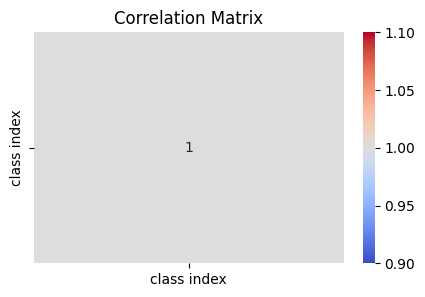

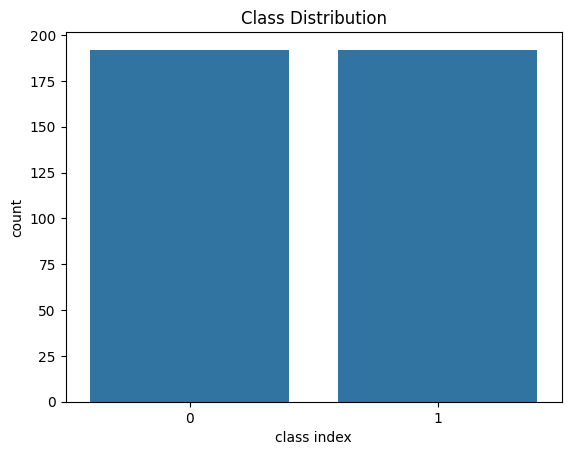

In [ ]:
# Step 8: Detailed Classification Report with Accident Likelihood Interpretation
from sklearn.metrics import classification_report

pred_labels = (model.predict(test_images) > 0.5).astype("int32")
print(classification_report(test_labels, pred_labels))

# Interpretation of the results
print("Interpretation of Predictions:")
for i, pred in enumerate(pred_labels):
    if pred == 0:  # Defective (high accident risk)
        print(f"Image {i+1}: High likelihood of an accident (defective).")
    else:  # Non-defective (low accident risk)
        print(f"Image {i+1}: Low likelihood of an accident (non-defective).")
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Select only numeric columns for correlation matrix
numeric_df = df.select_dtypes(include=[np.number])

# Compute the correlation matrix
correlation_matrix = numeric_df.corr()

# Visualizing the correlation matrix using a heatmap
plt.figure(figsize=(5, 3))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()
# Count plot for the 'class index' column
sns.countplot(x='class index', data=df)  # Adjust 'class index' to your label column
plt.title('Class Distribution')
plt.show()

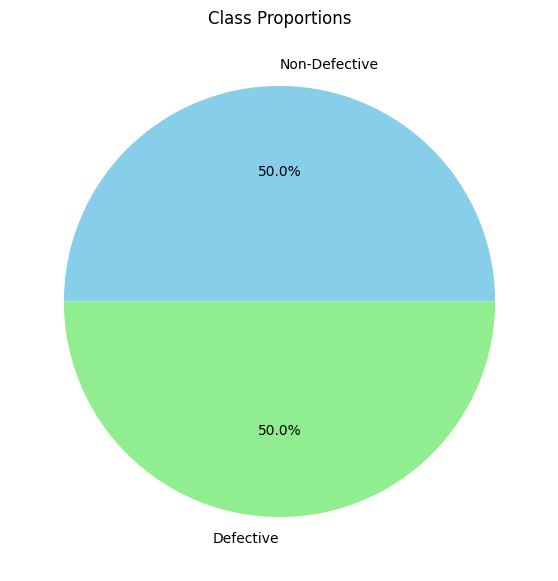

In [ ]:
# Pie chart for class distribution
df['class index'].value_counts().plot.pie(autopct='%1.1f%%', colors=['skyblue', 'lightgreen'],
                                          labels=['Non-Defective', 'Defective'], figsize=(7, 7))
plt.title('Class Proportions')
plt.ylabel('')
plt.show()


In [ ]:
model.save('final.h5')  # Example filename


In [ ]:
from google.colab import files
files.download('final.h5')  # Replace with your actual model filename


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Install seaborn if not already installed
!pip install seaborn

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import os


Saving archive (6).zip to archive (6) (1).zip
Uploaded file: archive (6) (1).zip
Extracted ZIP file to: /content/extracted_data
1/1 ━━━━━━━━━━━━━━━━━━━━ 17s 17s/step


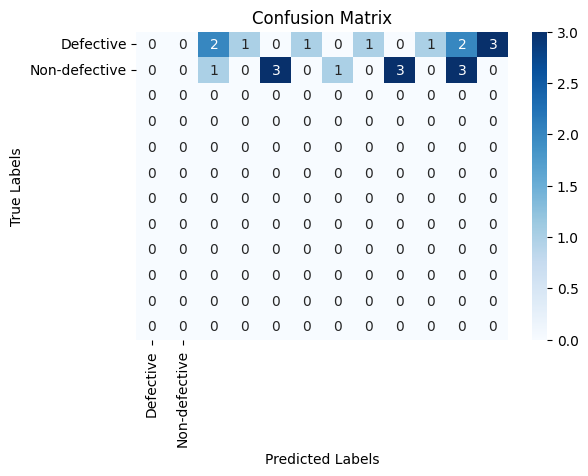

ValueError: Number of classes, 12, does not match size of target_names, 2. Try specifying the labels parameter

In [ ]:
# Step 1: Upload ZIP File
from google.colab import files
import zipfile
import os

# Upload the ZIP file
uploaded = files.upload()

# Assuming only one file is uploaded, get the file name
zip_file_name = list(uploaded.keys())[0]
print(f'Uploaded file: {zip_file_name}')

# Step 2: Extract the ZIP file
extract_folder = '/content/extracted_data'
os.makedirs(extract_folder, exist_ok=True)

# Extract the contents of the ZIP file
with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

print(f'Extracted ZIP file to: {extract_folder}')

# Step 3: Load Images from the Extracted Folders
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Load the pre-trained model (VGG16)
model = VGG16(weights='imagenet', include_top=False, pooling='avg')

# Helper function to load and preprocess images
def load_and_preprocess_image(img_path, target_size=(224, 224)):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    return preprocess_input(img_array)

# Function to get images and true labels from specified class directories
def load_images_from_folder(defective_path, non_defective_path):
    images = []
    labels = []

    # Load images from Defective
    if os.path.isdir(defective_path):
        for img_file in os.listdir(defective_path):
            img_path = os.path.join(defective_path, img_file)
            img = load_and_preprocess_image(img_path)
            images.append(img)
            labels.append(0)  # 0 for Defective
    else:
        print(f"Directory {defective_path} does not exist.")

    # Load images from Non-defective
    if os.path.isdir(non_defective_path):
        for img_file in os.listdir(non_defective_path):
            img_path = os.path.join(non_defective_path, img_file)
            img = load_and_preprocess_image(img_path)
            images.append(img)
            labels.append(1)  # 1 for Non-defective
    else:
        print(f"Directory {non_defective_path} does not exist.")

    # Return an empty array if no images are found to avoid errors
    if len(images) == 0:
        return np.empty((0, 224, 224, 3)), np.array([])

    return np.vstack(images), np.array(labels)

# Specify the paths for each dataset manually after extraction
train_defective_path = os.path.join(extract_folder, 'train', 'Defective')
train_non_defective_path = os.path.join(extract_folder, 'train', 'Non defective')

valid_defective_path = os.path.join(extract_folder, 'valid', 'Defective')
valid_non_defective_path = os.path.join(extract_folder, 'valid', 'Non defective')

test_defective_path = os.path.join(extract_folder, 'test', 'Defective')
test_non_defective_path = os.path.join(extract_folder, 'test', 'Non defective')

# Load train, validation, and test images and labels
train_images, train_labels = load_images_from_folder(train_defective_path, train_non_defective_path)
valid_images, valid_labels = load_images_from_folder(valid_defective_path, valid_non_defective_path)
test_images, true_labels = load_images_from_folder(test_defective_path, test_non_defective_path)

# Check if train/test images are empty
if len(test_images) == 0 or len(true_labels) == 0:
    print("No test images found. Please check the dataset.")
else:
    # Make predictions using the pre-trained model
    predictions = model.predict(test_images)
    predicted_labels = np.argmax(predictions, axis=1)  # Get the index of the highest probability

    # Compute confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)

    # Plot the confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Defective', 'Non-defective'], yticklabels=['Defective', 'Non-defective'])
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    # Print classification report for additional metrics
    print(classification_report(true_labels, predicted_labels, target_names=['Defective', 'Non defective']))
